### Feature Extraction and Normalization

In [3]:
import os
import pandas as pd
#import six
import glob
import SimpleITK as sitk
from radiomics import featureextractor
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
#import nibabel as nib

In [2]:
# find unique GTV values
file_info = pd.read_csv('file_info0404.csv')
file_info.head()
unique = pd.unique(file_info.GTV_name)

In [3]:
heart_df = pd.read_csv('heart_intensity_statistics0404.csv')
info_df = pd.read_csv('match_paths0406.csv')
gtv_df = pd.read_csv('GTV_use.csv')
gtv_df.head()

,GTV_name,GTV_use
0,"['Struct_GTV.nii.gz', 'Struct_GTV_3MM.nii.gz',...",Struct_GTV.nii.gz
1,"['Struct_GTVp^LUL1.nii.gz', 'Struct_GTVp^LUL2....","Struct_GTVp^LUL1.nii.gz, Struct_GTVp^LUL2.nii.gz"
2,"['Struct_GTVp^LUL1.nii.gz', 'Struct_GTVp^LUL2....","Struct_GTVp^LUL1.nii.gz, Struct_GTVp^LUL2.nii.gz"
3,['Struct_GTV.nii.gz'],Struct_GTV.nii.gz
4,"['Struct_GTV.nii.gz', 'Struct_LUNGS_GTV.nii.gz']",Struct_GTV.nii.gz


### N4 Bias Field Correction

In [35]:
def correction(img_path, pat_id, frac_id):
    '''
    Create new MR folder for corrected img
    N4 Bias Field Correction

    Args: img_path: path to exported nii.gz images in match_paths0406.csv
    img_save_path: main path to save corrected images
    '''
    try:
        # print(image.GetPixelIDTypeAsString()) # original image size sitkUInt16
        input_img = sitk.ReadImage(img_path)
        mask_img = sitk.OtsuThreshold(input_img,0,1,200)
        input_img = sitk.Cast(input_img, sitk.sitkFloat32)
        corrector = sitk.N4BiasFieldCorrectionImageFilter()
        output_img = corrector.Execute(input_img,mask_img)
        output_img = sitk.Cast(output_img, sitk.sitkInt16)
        # image save path
        p = img_path.replace('.nii.gz', '_corrected.nii.gz')
        sitk.WriteImage(output_img, p)
        print('patient_id:{} fraction: {} corrected'.format(pat_id, frac_id))
    except Exception as e:
        print('patient_id:{} fraction: {} error:{}'.format(pat_id, frac_id, e))
        p = ''
    return p

In [36]:
for i in range(235, len(info_df.patient_id)):
    N4_mr_stored_path.append(correction(info_df.mr_stored_path[i], info_df.patient_id[i], info_df.fraction[i]))

NameError: name 'N4_mr_stored_path' is not defined

In [ ]:
# store N4 corrected mr path info
N4_mr_stored_path = []
for i in range(0, len(info_df.patient_id)):
    if isinstance(info_df.mr_stored_path[i], float) == False:
        N4_mr_stored_path.append(info_df.mr_stored_path[i].replace('.nii.gz', '_corrected.nii.gz'))
    else:
        N4_mr_stored_path.append('')
N4_df = pd.DataFrame({'pat_id': info_df.patient_id, 'fraction': info_df.fraction, 'N4_mr_stored_path': N4_mr_stored_path})
N4_df
#N4_df.to_csv('N4_mr_stored_path.csv')
# store all file info in info_df
info_df['N4_mr_stored_path'] = N4_df['N4_mr_stored_path']
info_df.to_csv('match_paths0410.csv')

### Normalization by median heart intensity value
* new arrary = np.array(mri_array)/median of heart intensity


* First, find the correct GTVs to use. If 1 fraction has 2 GTVs, then consider separate GTV cases

* Second, find the median heart intensity value for each patient fraction.

In [ ]:
# ignore .DS_Store
def list_dir(path):
    return glob.glob(os.path.join(path, '*'))

In [ ]:
# Find Correct GTV to use
def GTV_to_use(pat_id, rt_struct_stored_path, gtv_df):
    '''
    Step 1: check GTVs in RT structure stored path
    Step 2: select correct GTVs to use

    Args: 
    pat_id: patient id in 
    rt_struct_stored_path: RT structure stored path in match_paths0404.csv
    gtv_df: list of correct GTVs to use matched with unique GTVs
    '''
    GTVs = []
    GTVs_use = []
    GTVs_use_path = []
    i = 0
    gtv_df['New_GTV_name'] = gtv_df['GTV_name'].astype(str)

    for rtst in rt_struct_stored_path:
        temp = []
        gtv_use = []
        if pd.isnull(rtst) == False:
            i += 1
            for fname in os.listdir(rtst):
                if 'GTV' in fname:
                    temp.append(fname)
            #print(temp)
            #for gtvs in gtv_df['New_GTV_name']:
                #if gtvs == str(temp):
            gtv_use = gtv_df.loc[gtv_df['New_GTV_name'] == str(temp), 'GTV_use'].iloc[0]
            gtv_use_path = ''
            # Case 1: if store gtv_use_path as string
            #for gtv in gtv_use.split(', '):
            #    gtv_use_path += (rtst + '/' + gtv + ', ')
            #gtv_use_path = gtv_use_path[:-2]
            # Case 2: if store gtv_use_path as list
            #GTVs_use_path.append(gtv_use_path)
            gtv_use_path = [(rtst + '/' + gtv) for gtv in gtv_use.split(', ')]
            GTVs_use_path.append(gtv_use_path)
            #print(i, gtv_use)
            GTVs_use.append(gtv_use)
            GTVs.append(temp)
        else:
            i += 1
            print(i, rtst, 'error') # print error for patient index
            GTVs_use.append('')
            GTVs_use_path.append('')
            GTVs.append('')
    #return GTVs, GTVs_use
    df = pd.DataFrame({'PMRN': pat_id, 'GTV_name': GTVs, 'GTV_use': GTVs_use, 'GTV_use_path': GTVs_use_path})
    return df

In [ ]:
df = GTV_to_use(info_df.patient_id, info_df.rt_struct_stored_path, gtv_df)
df.to_csv('GTV_to_use0406.csv')
# append GTV_use to info_df (match_paths0406.csv)
info_df['GTV_rtst'] = df['GTV_use']
info_df['GTV_rtst_path'] = df['GTV_use_path']
info_df.to_csv('match_paths0406.csv')

248 nan error
251 nan error


In [ ]:
# get heart intensity values
def heart_intensity(mri_path, heart_st_path, save_path, pat_id, fraction):
    '''find path to heart RTst, get intensity histogram and statistics (median, mean, Q1, Q3, std, max, min) for each fraction

    Args: 
    mri_path = path to mri in 'match_paths0404.csv' or dataframe 'df'
    heart_st_path = path to rt_struct_stored_path in 'match_paths0404.csv'
    save_path = main path to save histograms
    pat_id = patient id in 'match_paths0404.csv'
    fraction = patient fraction # in 'match_paths0404.csv'
    '''
    if pd.isnull(mri_path) == False:
        if os.path.exists(mri_path):
            mri_array = sitk.GetArrayFromImage(sitk.ReadImage(mri_path))
    else:
        print('patient_id:{} fraction_id:{} no mri_path'.format(pat_id, fraction))
        med = 0
        mean = 0
        Q1 = 0
        Q3 = 0
        std = 0
        max_num = 0
        min_num = 0

    # get path to heart structure
    if pd.isnull(heart_st_path) == False:
        if os.path.exists(heart_st_path):
            heart_st_path_new = os.path.join(heart_st_path, ''.join(x for x in os.listdir(heart_st_path) 
                                                                if x in ['Struct_Heart.nii.gz', 'Struct_Heart1.nii.gz', 'Struct_HEART.nii.gz']))
    else:
        print('patient_id:{} fraction_id:{} no heart_st_path'.format(pat_id, fraction))
        heart_st_path_new = ''
        med = 0
        mean = 0
        Q1 = 0
        Q3 = 0
        std = 0
        max_num = 0
        min_num = 0

    try:
        heart_st_array = sitk.GetArrayFromImage(sitk.ReadImage(heart_st_path_new)) # mask array
        # fill holes of heart mask
        heart_st_array_fill = ndimage.binary_fill_holes(heart_st_array)
        mri_heart = mri_array * heart_st_array_fill # (144, 300, 334)
        mri_heart_rz = mri_heart[mri_heart!=0]
        mri_heart_rz_flat = mri_heart_rz.flatten()

        # record median, mean, Q1, Q3, std, max, min
        med = np.median(mri_heart_rz_flat)
        mean = np.mean(mri_heart_rz_flat)
        Q1 = np.percentile(mri_heart_rz_flat, 25)
        Q3 = np.percentile(mri_heart_rz_flat, 75)
        std = np.std(mri_heart_rz_flat)
        max_num = np.max(mri_heart_rz_flat)
        min_num = np.min(mri_heart_rz_flat)

        plt.figure(figsize=(12,8))
        #plt.plot(ndi.histogram(mri_heart_rz_flat, min=mri_heart_rz_flat.min(), max=mri_heart_rz_flat.max(), bins=(mri_heart_rz_flat.max()-mri_heart_rz_flat.min())))
        plt.plot(ndi.histogram(mri_heart_rz_flat, min=0, max=1470, bins=1470)) # max of heart intensity values for all patients
        plt.axvline(med, color = 'r', linestyle = '--', label = f'median {med}')
        plt.axvline(Q1, color = 'g', linestyle = '--', label = f'Q1 {Q1}')
        plt.axvline(Q3, color = 'b', linestyle = '--', label = f'Q3 {Q3}')
        plt.title('Heart Intensity Distribution (remove 0s)')
        plt.legend()
        #plt.show()
        temp = heart_st_path.split('/')[-1].split('_')
        plt.savefig(os.path.join(save_path, (str(pat_id) + '_' + temp[0] + '_' + temp[1] + '_' + fraction + '_' + '1.png')))
        plt.close()

    except Exception as e:
        print('patient_id:{} fraction_id:{} error:{}'.format(pat_id, fraction, e))
        med = 0
        mean = 0
        Q1 = 0
        Q3 = 0
        std = 0
        max_num = 0
        min_num = 0

    return heart_st_path_new, med, mean, Q1, Q3, std, max_num, min_num

In [ ]:
#heart_stats = pd.DataFrame({'PMRN': pat_ids, 'Fraction': frac_ids, 'Struct_Heart_name': H_strs})
save_path = '/Volumes/BWH-KANNLAB/Nancy/Lung_Cancer_Radiomics/Heart_Intensity/N4Histograms'
medians = []
means = []
Q1s = []
Q3s = []
stds = []
max_nums = []
min_nums = []
heart_st_paths = []
for i in range(0, len(info_df.patient_id)): # len(df.patient_id)
    heart_st_path_new, med, mean, Q1, Q3, std, max_num, min_num = heart_intensity(info_df.N4_mr_stored_path[i], # after N4 correction, change mr_stored_path to N4_mr_stored_path
                                                                                  info_df.rt_struct_stored_path[i], save_path, info_df.patient_id[i], info_df.fraction[i])
    heart_st_paths.append(heart_st_path_new)
    medians.append(med)
    means.append(mean)
    Q1s.append(Q1)
    Q3s.append(Q3)
    stds.append(std)
    max_nums.append(max_num)
    min_nums.append(min_num)
# count number of occurrences in array
# np.count_nonzero(mri_heart_rz.flatten() == 147)
heart_df = pd.DataFrame({'pat_id': info_df.patient_id, 'fraction_id': info_df.fraction, 'heart_rtst_path': heart_st_paths, 'Median': medians, 'Mean': means, 
                         'Q1': Q1s, 'Q3': Q3s, 'std': stds, 'max': max_nums, 'min': min_nums})
heart_df.head()
heart_df.to_csv('heart_intensity_statistics0410.csv')

patient_id:10061253158 fraction_id:2 no heart_st_path
patient_id:10061253158 fraction_id:2 error:Exception thrown in SimpleITK ImageFileReader_Execute: /Users/runner/work/1/sitk/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "" does not exist.
patient_id:10086126256 fraction_id:2 no heart_st_path
patient_id:10086126256 fraction_id:2 error:Exception thrown in SimpleITK ImageFileReader_Execute: /Users/runner/work/1/sitk/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "" does not exist.


In [ ]:
# ? check the heart intensity difference before and after N4 (heart_intensity_statistics0404.csv VS. heart_intensity_statistics0410.csv)

In [ ]:
# Normalization
# new array = np.array(mri_array)/median of heart intensity
def normalization(pat_id, fraction, mri_path, med):
    '''
    normalize the image by dividing median signal value in the heart
    
    Args:
    mri_path: path to mri_image. Note: use N4_mr_stored_path after N4 correction
    med: median of heart intensity
    '''
    #GTV_rtst_path = str(GTV_rtst_path)[1:-1].replace("'", "")
    if pd.isnull(mri_path) == False:
        try:
            mr_input = sitk.ReadImage(mri_path)
            mr_array = sitk.GetArrayFromImage(sitk.ReadImage(mri_path))
            norm_array = np.array(mr_array)/med
            norm_img = sitk.GetImageFromArray(norm_array)
            # norm_img.CopyInformation(mr_input)
            # set same spacing and origin values
            norm_img.SetSpacing(mr_input.GetSpacing())
            norm_img.SetOrigin(mr_input.GetOrigin())
            sitk.WriteImage(norm_img, mri_path.replace('_corrected.nii.gz', '_cor_norm.nii.gz'))
            print('patient_id:{} fraction: {} normalized'.format(pat_id, fraction))
            #img = nib.Nifti1Image(norm_array, nib.load(mri_path).affine)
            #nib.save(img, mri_path.replace('_corrected.nii.gz', '_cor_norm.nii.gz'))
        except Exception as e:
            print('patient_id:{} fraction_id:{} error:{}'.format(pat_id, fraction, e))
    else:
        print('patient_id:{} fraction_id:{} no mri_path'.format(pat_id, fraction))

In [ ]:
#heart_df['GTV_rtst_path'] = info_df.GTV_rtst_path
# also explode heart_df_1 (don't need to explode)
#heart_df_1 = heart_df.explode('GTV_rtst_path').reset_index(drop=True)
# heart_df_1.shape (295, 11)
for i in range(61, len(info_df.patient_id)):
    normalization(info_df.patient_id[i], info_df.fraction[i], info_df.N4_mr_stored_path[i], heart_df.Median[i])

patient_id:10089885502 fraction: 4 normalized
patient_id:10089885502 fraction: 5 normalized
patient_id:10088707426 fraction: 1 normalized
patient_id:10088707426 fraction: 2 normalized
patient_id:10088707426 fraction: 4 normalized
patient_id:10026629575 fraction: 1 normalized
patient_id:10026629575 fraction: 2 normalized
patient_id:10026629575 fraction: 3 normalized
patient_id:10026629575 fraction: 4 normalized
patient_id:10026629575 fraction: 5 normalized
patient_id:10074696369 fraction: 1 normalized
patient_id:10074696369 fraction: 2 normalized
patient_id:10074696369 fraction: 3 normalized
patient_id:10074696369 fraction: 4 normalized
patient_id:10074696369 fraction: 5 normalized
patient_id:10026040096 fraction: 1 normalized
patient_id:10026040096 fraction: 2 normalized
patient_id:10026040096 fraction: 3 normalized
patient_id:10026040096 fraction: 4 normalized
patient_id:10026040096 fraction: 5 normalized
patient_id:10043063741 fraction: 1 normalized
patient_id:10043063741 fraction: 2

In [ ]:
# store Normalization mr path info
N4_Nor_mr_stored_path = []
for i in range(0, len(info_df.patient_id)):
    if isinstance(info_df.mr_stored_path[i], float) == False:
        N4_Nor_mr_stored_path.append(info_df.mr_stored_path[i].replace('.nii.gz', '_cor_norm.nii.gz'))
    else:
        N4_Nor_mr_stored_path.append('')
N4_Nor_df = pd.DataFrame({'pat_id': info_df.patient_id, 'fraction': info_df.fraction, 'N4_Nor_mr_stored_path': N4_Nor_mr_stored_path})
info_df['N4_Nor_mr_stored_path'] = N4_Nor_df['N4_Nor_mr_stored_path']
info_df.to_csv('match_paths0412.csv')

In [ ]:
# for patient with more than 1 gtv, restore as pat_1, pat_2
def explode_gtv_list(info_df):
    '''
    for patient with more than 1 gtv, restore as pat_1, pat_2
    Args: file columns from info_df (match_paths0410.csv)
    '''
    info_df_1 = info_df.explode('GTV_rtst_path').reset_index(drop=True)
    info_df_1['gtv_index'] = info_df_1.groupby('rt_struct_stored_path').cumcount() + 1
    for i in range(0, len(info_df_1['rt_struct_stored_path'])):
        p = info_df_1['rt_struct_stored_path'][i]
        if pd.isnull(p) is True:
            info_df_1['gtv_index'][i] = 0
    return info_df_1

In [ ]:
info_df_1 = explode_gtv_list(info_df)
info_df_1.to_csv('match_paths04122.csv') # final version for feature extraction

<ipython-input-397-348930d43115>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_df_1['gtv_index'][i] = 0


### Feature Extraction

##### Feature Extraction using updated source code from pyradiomics
see local files Kann Lab/Lung Cancer/imageoperations.py & Kann Lab/Lung Cancer/radiomics.featureextractor.N.ipynb

In [4]:
# copied feature extraction code from radiomics.featureextractor.N.ipynb
# -*- coding: utf-8 -*-
from __future__ import print_function

import collections
from itertools import chain
import json
import logging
import os
import pathlib

import pykwalify.core
import SimpleITK as sitk
import six

#from radiomics import generalinfo, getFeatureClasses, getImageTypes, getParameterValidationFiles, imageoperations
from radiomics import generalinfo, getFeatureClasses, getImageTypes, getParameterValidationFiles


logger = logging.getLogger(__name__)
geometryTolerance = None

import imageoperations

In [5]:
class RadiomicsFeatureExtractor:
  r"""
  Wrapper class for calculation of a radiomics signature.
  At and after initialisation various settings can be used to customize the resultant signature.
  This includes which classes and features to use, as well as what should be done in terms of preprocessing the image
  and what images (original and/or filtered) should be used as input.

  Then a call to :py:func:`execute` generates the radiomics
  signature specified by these settings for the passed image and labelmap combination. This function can be called
  repeatedly in a batch process to calculate the radiomics signature for all image and labelmap combinations.

  At initialization, a parameters file (string pointing to yaml or json structured file) or dictionary can be provided
  containing all necessary settings (top level containing keys "setting", "imageType" and/or "featureClass). This is
  done by passing it as the first positional argument. If no positional argument is supplied, or the argument is not
  either a dictionary or a string pointing to a valid file, defaults will be applied.
  Moreover, at initialisation, custom settings (*NOT enabled image types and/or feature classes*) can be provided
  as keyword arguments, with the setting name as key and its value as the argument value (e.g. ``binWidth=25``).
  Settings specified here will override those in the parameter file/dict/default settings.
  For more information on possible settings and customization, see
  :ref:`Customizing the Extraction <radiomics-customization-label>`.

  By default, all features in all feature classes are enabled.
  By default, only `Original` input image is enabled (No filter applied).
  """

  def __init__(self, med = 0, *args, **kwargs):
    global logger

    self.settings = {}
    self.enabledImagetypes = {}
    self.enabledFeatures = {}

    self.featureClassNames = list(getFeatureClasses().keys())

    if len(args) == 1 and isinstance(args[0], dict):
      logger.info("Loading parameter dictionary")
      self._applyParams(paramsDict=args[0])
    elif len(args) == 1 and (isinstance(args[0], six.string_types) or isinstance(args[0], pathlib.PurePath)):
      if not os.path.isfile(args[0]):
        raise IOError("Parameter file %s does not exist." % args[0])
      logger.info("Loading parameter file %s", str(args[0]))
      self._applyParams(paramsFile=args[0])
    else:
      # Set default settings and update with and changed settings contained in kwargs
      self.settings = self._getDefaultSettings()
      logger.info('No valid config parameter, using defaults: %s', self.settings)

      self.enabledImagetypes = {'Original': {}}
      logger.info('Enabled image types: %s', self.enabledImagetypes)

      for featureClassName in self.featureClassNames:
        if featureClassName == 'shape2D':  # Do not enable shape2D by default
          continue
        self.enabledFeatures[featureClassName] = []
      logger.info('Enabled features: %s', self.enabledFeatures)

    if len(kwargs) > 0:
      logger.info('Applying custom setting overrides: %s', kwargs)
      self.settings.update(kwargs)
      logger.debug("Settings: %s", self.settings)

    if self.settings.get('binCount', None) is not None:
      logger.warning('Fixed bin Count enabled! However, we recommend using a fixed bin Width. See '
                     'http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more '
                     'details')

    self._setTolerance()

  def _setTolerance(self):
    global geometryTolerance, logger
    geometryTolerance = self.settings.get('geometryTolerance')
    if geometryTolerance is not None:
      logger.debug('Setting SimpleITK tolerance to %s', geometryTolerance)
      sitk.ProcessObject.SetGlobalDefaultCoordinateTolerance(geometryTolerance)
      sitk.ProcessObject.SetGlobalDefaultDirectionTolerance(geometryTolerance)

  def addProvenance(self, provenance_on=True):
    """
    Enable or disable reporting of additional information on the extraction. This information includes toolbox version,
    enabled input images and applied settings. Furthermore, additional information on the image and region of interest
    (ROI) is also provided, including original image spacing, total number of voxels in the ROI and total number of
    fully connected volumes in the ROI.

    To disable this, call ``addProvenance(False)``.
    """
    self.settings['additionalInfo'] = provenance_on

  @staticmethod
  def _getDefaultSettings():
    """
    Returns a dictionary containg the default settings specified in this class. These settings cover global settings,
    such as ``additionalInfo``, as well as the image pre-processing settings (e.g. resampling). Feature class specific
    are defined in the respective feature classes and and not included here. Similarly, filter specific settings are
    defined in ``imageoperations.py`` and also not included here.
    """
    return {'minimumROIDimensions': 2,
            'minimumROISize': None,  # Skip testing the ROI size by default
            'normalize': False,
            'normalizeScale': 1,
            'removeOutliers': None,
            'resampledPixelSpacing': None,  # No resampling by default
            'interpolator': 'sitkBSpline',  # Alternative: sitk.sitkBSpline
            'preCrop': False,
            'padDistance': 5,
            'distances': [1],
            'force2D': False,
            'force2Ddimension': 0,
            'resegmentRange': None,  # No resegmentation by default
            'label': 1,
            'additionalInfo': True}

  def loadParams(self, paramsFile):
    """
    Parse specified parameters file and use it to update settings, enabled feature(Classes) and image types. For more
    information on the structure of the parameter file, see
    :ref:`Customizing the extraction <radiomics-customization-label>`.

    If supplied file does not match the requirements (i.e. unrecognized names or invalid values for a setting), a
    pykwalify error is raised.
    """
    self._applyParams(paramsFile=paramsFile)

  def loadJSONParams(self, JSON_configuration):
    """
    Pars JSON structured configuration string and use it to update settings, enabled feature(Classes) and image types.
    For more information on the structure of the parameter file, see
    :ref:`Customizing the extraction <radiomics-customization-label>`.

    If supplied string does not match the requirements (i.e. unrecognized names or invalid values for a setting), a
    pykwalify error is raised.
    """
    parameter_data = json.loads(JSON_configuration)
    self._applyParams(paramsDict=parameter_data)

  def _applyParams(self, paramsFile=None, paramsDict=None):
    """
    Validates and applies a parameter dictionary. See :py:func:`loadParams` and :py:func:`loadJSONParams` for more info.
    """
    global logger

    # Ensure pykwalify.core has a log handler (needed when parameter validation fails)
    if len(pykwalify.core.log.handlers) == 0 and len(logging.getLogger().handlers) == 0:
      # No handler available for either pykwalify or root logger, provide first radiomics handler (outputs to stderr)
      pykwalify.core.log.addHandler(logging.getLogger('radiomics').handlers[0])

    schemaFile, schemaFuncs = getParameterValidationFiles()
    c = pykwalify.core.Core(source_file=paramsFile, source_data=paramsDict,
                            schema_files=[schemaFile], extensions=[schemaFuncs])
    params = c.validate()
    logger.debug('Parameters parsed, input is valid.')

    enabledImageTypes = params.get('imageType', {})
    enabledFeatures = params.get('featureClass', {})
    settings = params.get('setting', {})
    voxelSettings = params.get('voxelSetting', {})

    logger.debug("Applying settings")

    if len(enabledImageTypes) == 0:
      self.enabledImagetypes = {'Original': {}}
    else:
      self.enabledImagetypes = enabledImageTypes

    logger.debug("Enabled image types: %s", self.enabledImagetypes)

    if len(enabledFeatures) == 0:
      self.enabledFeatures = {}
      for featureClassName in self.featureClassNames:
        self.enabledFeatures[featureClassName] = []
    else:
      self.enabledFeatures = enabledFeatures

    logger.debug("Enabled features: %s", self.enabledFeatures)

    # Set default settings and update with and changed settings contained in kwargs
    self.settings = self._getDefaultSettings()
    self.settings.update(settings)
    self.settings.update(voxelSettings)

    logger.debug("Settings: %s", settings)

  #def execute(self, imageFilepath, maskFilepath, label=None, label_channel=None, voxelBased=False):
  def execute(self, imageFilepath, maskFilepath, label=None, label_channel=None, voxelBased=False, med = 0):
    """
    Compute radiomics signature for provide image and mask combination. It comprises of the following steps:

    1. Image and mask are loaded and normalized/resampled if necessary.
    2. Validity of ROI is checked using :py:func:`~imageoperations.checkMask`, which also computes and returns the
       bounding box.
    3. If enabled, provenance information is calculated and stored as part of the result. (Not available in voxel-based
       extraction)
    4. Shape features are calculated on a cropped (no padding) version of the original image. (Not available in
       voxel-based extraction)
    5. If enabled, resegment the mask based upon the range specified in ``resegmentRange`` (default None: resegmentation
       disabled).
    6. Other enabled feature classes are calculated using all specified image types in ``_enabledImageTypes``. Images
       are cropped to tumor mask (no padding) after application of any filter and before being passed to the feature
       class.
    7. The calculated features is returned as ``collections.OrderedDict``.

    :param imageFilepath: SimpleITK Image, or string pointing to image file location
    :param maskFilepath: SimpleITK Image, or string pointing to labelmap file location
    :param label: Integer, value of the label for which to extract features. If not specified, last specified label
        is used. Default label is 1.
    :param label_channel: Integer, index of the channel to use when maskFilepath yields a SimpleITK.Image with a vector
        pixel type. Default index is 0.
    :param voxelBased: Boolean, default False. If set to true, a voxel-based extraction is performed, segment-based
        otherwise.
    :returns: dictionary containing calculated signature ("<imageType>_<featureClass>_<featureName>":value).
        In case of segment-based extraction, value type for features is float, if voxel-based, type is SimpleITK.Image.
        Type of diagnostic features differs, but can always be represented as a string.
    """
    global geometryTolerance, logger
    _settings = self.settings.copy()

    tolerance = _settings.get('geometryTolerance')
    additionalInfo = _settings.get('additionalInfo', False)
    resegmentShape = _settings.get('resegmentShape', False)

    if label is not None:
      _settings['label'] = label
    else:
      label = _settings.get('label', 1)

    if label_channel is not None:
      _settings['label_channel'] = label_channel

    if geometryTolerance != tolerance:
      self._setTolerance()

    if additionalInfo:
      generalInfo = generalinfo.GeneralInfo()
      generalInfo.addGeneralSettings(_settings)
      generalInfo.addEnabledImageTypes(self.enabledImagetypes)
    else:
      generalInfo = None

    if voxelBased:
      _settings['voxelBased'] = True
      kernelRadius = _settings.get('kernelRadius', 1)
      logger.info('Starting voxel based extraction')
    else:
      kernelRadius = 0

    logger.info('Calculating features with label: %d', label)
    logger.debug('Enabled images types: %s', self.enabledImagetypes)
    logger.debug('Enabled features: %s', self.enabledFeatures)
    logger.debug('Current settings: %s', _settings)

    # 1. Load the image and mask
    featureVector = collections.OrderedDict()
    #image, mask = self.loadImage(imageFilepath, maskFilepath, generalInfo, **_settings)
    image, mask = self.loadImage(imageFilepath, maskFilepath, generalInfo, med, **_settings)

    # 2. Check whether loaded mask contains a valid ROI for feature extraction and get bounding box
    # Raises a ValueError if the ROI is invalid
    boundingBox, correctedMask = imageoperations.checkMask(image, mask, **_settings)

    # Update the mask if it had to be resampled
    if correctedMask is not None:
      if generalInfo is not None:
        generalInfo.addMaskElements(image, correctedMask, label, 'corrected')
      mask = correctedMask

    logger.debug('Image and Mask loaded and valid, starting extraction')

    # 5. Resegment the mask if enabled (parameter regsegmentMask is not None)
    resegmentedMask = None
    if _settings.get('resegmentRange', None) is not None:
      resegmentedMask = imageoperations.resegmentMask(image, mask, **_settings)

      # Recheck to see if the mask is still valid, raises a ValueError if not
      boundingBox, correctedMask = imageoperations.checkMask(image, resegmentedMask, **_settings)

      if generalInfo is not None:
        generalInfo.addMaskElements(image, resegmentedMask, label, 'resegmented')

    # 3. Add the additional information if enabled
    if generalInfo is not None:
      featureVector.update(generalInfo.getGeneralInfo())

    # if resegmentShape is True and resegmentation has been enabled, update the mask here to also use the
    # resegmented mask for shape calculation (e.g. PET resegmentation)
    if resegmentShape and resegmentedMask is not None:
      mask = resegmentedMask

    if not voxelBased:
      # 4. If shape descriptors should be calculated, handle it separately here
      featureVector.update(self.computeShape(image, mask, boundingBox, **_settings))

    # (Default) Only use resegemented mask for feature classes other than shape
    # can be overridden by specifying `resegmentShape` = True
    if not resegmentShape and resegmentedMask is not None:
      mask = resegmentedMask

    # 6. Calculate other enabled feature classes using enabled image types
    # Make generators for all enabled image types
    logger.debug('Creating image type iterator')
    imageGenerators = []
    for imageType, customKwargs in six.iteritems(self.enabledImagetypes):
      args = _settings.copy()
      args.update(customKwargs)
      logger.info('Adding image type "%s" with custom settings: %s' % (imageType, str(customKwargs)))
      imageGenerators = chain(imageGenerators, getattr(imageoperations, 'get%sImage' % imageType)(image, mask, **args))

    logger.debug('Extracting features')
    # Calculate features for all (filtered) images in the generator
    for inputImage, imageTypeName, inputKwargs in imageGenerators:
      logger.info('Calculating features for %s image', imageTypeName)
      inputImage, inputMask = imageoperations.cropToTumorMask(inputImage, mask, boundingBox, padDistance=kernelRadius)
      featureVector.update(self.computeFeatures(inputImage, inputMask, imageTypeName, **inputKwargs))

    logger.debug('Features extracted')

    return featureVector

  @staticmethod
  #def loadImage(ImageFilePath, MaskFilePath, generalInfo=None, **kwargs):
  # self.loadImage(imageFilepath, maskFilepath, generalInfo, med=0, **_settings)
  def loadImage(ImageFilePath, MaskFilePath, generalInfo=None, med = 0, **kwargs):
    """
    Load and pre-process the image and labelmap.
    If ImageFilePath is a string, it is loaded as SimpleITK Image and assigned to ``image``,
    if it already is a SimpleITK Image, it is just assigned to ``image``.
    All other cases are ignored (nothing calculated).
    Equal approach is used for assignment of ``mask`` using MaskFilePath. If necessary, a segmentation object (i.e. mask
    volume with vector-image type) is then converted to a labelmap (=scalar image type). Data type is forced to UInt32.
    See also :py:func:`~imageoperations.getMask()`.

    If normalizing is enabled image is first normalized before any resampling is applied.

    If resampling is enabled, both image and mask are resampled and cropped to the tumor mask (with additional
    padding as specified in padDistance) after assignment of image and mask.

    :param ImageFilePath: SimpleITK.Image object or string pointing to SimpleITK readable file representing the image
                          to use.
    :param MaskFilePath: SimpleITK.Image object or string pointing to SimpleITK readable file representing the mask
                         to use.
    :param generalInfo: GeneralInfo Object. If provided, it is used to store diagnostic information of the
                        pre-processing.
    :param kwargs: Dictionary containing the settings to use for this particular image type.
    :return: 2 SimpleITK.Image objects representing the loaded image and mask, respectively.
    """
    global logger

    normalize = kwargs.get('normalize', False)
    interpolator = kwargs.get('interpolator')
    resampledPixelSpacing = kwargs.get('resampledPixelSpacing')
    preCrop = kwargs.get('preCrop', False)
    label = kwargs.get('label', 1)

    logger.info('Loading image and mask')
    if isinstance(ImageFilePath, six.string_types) and os.path.isfile(ImageFilePath):
      image = sitk.ReadImage(ImageFilePath)
    elif isinstance(ImageFilePath, sitk.SimpleITK.Image):
      image = ImageFilePath
    else:
      raise ValueError('Error reading image Filepath or SimpleITK object')

    if isinstance(MaskFilePath, six.string_types) and os.path.isfile(MaskFilePath):
      mask = sitk.ReadImage(MaskFilePath)
    elif isinstance(MaskFilePath, sitk.SimpleITK.Image):
      mask = MaskFilePath
    else:
      raise ValueError('Error reading mask Filepath or SimpleITK object')

    # process the mask
    mask = imageoperations.getMask(mask, **kwargs)

    if generalInfo is not None:
      generalInfo.addImageElements(image)
      # Do not include the image here, as the overlap between image and mask have not been checked
      # It is therefore possible that image and mask do not align, or even have different sizes.
      generalInfo.addMaskElements(None, mask, label)

    # This point is only reached if image and mask loaded correctly
    if normalize:
      #image = imageoperations.normalizeImage(image, **kwargs)
      image = imageoperations.normalizeImageNew(image, med, **kwargs)

    if interpolator is not None and resampledPixelSpacing is not None:
      image, mask = imageoperations.resampleImage(image, mask, **kwargs)
      if generalInfo is not None:
        generalInfo.addImageElements(image, 'interpolated')
        generalInfo.addMaskElements(image, mask, label, 'interpolated')

    elif preCrop:
      bb, correctedMask = imageoperations.checkMask(image, mask, **kwargs)
      if correctedMask is not None:
        # Update the mask if it had to be resampled
        mask = correctedMask
      if bb is None:
        # Mask checks failed
        raise ValueError('Mask checks failed during pre-crop')

      image, mask = imageoperations.cropToTumorMask(image, mask, bb, **kwargs)

    return image, mask

  def computeShape(self, image, mask, boundingBox, **kwargs):
    """
    Calculate the shape (2D and/or 3D) features for the passed image and mask.

    :param image: SimpleITK.Image object representing the image used
    :param mask: SimpleITK.Image object representing the mask used
    :param boundingBox: The boundingBox calculated by :py:func:`~imageoperations.checkMask()`, i.e. a tuple with lower
      (even indices) and upper (odd indices) bound of the bounding box for each dimension.
    :param kwargs: Dictionary containing the settings to use.
    :return: collections.OrderedDict containing the calculated shape features. If no features are calculated, an empty
      OrderedDict will be returned.
    """
    global logger
    featureVector = collections.OrderedDict()

    enabledFeatures = self.enabledFeatures

    croppedImage, croppedMask = imageoperations.cropToTumorMask(image, mask, boundingBox)

    # Define temporary function to compute shape features
    def compute(shape_type):
      logger.info('Computing %s', shape_type)
      featureNames = enabledFeatures[shape_type]
      shapeClass = getFeatureClasses()[shape_type](croppedImage, croppedMask, **kwargs)

      if featureNames is not None:
        for feature in featureNames:
          shapeClass.enableFeatureByName(feature)

      for (featureName, featureValue) in six.iteritems(shapeClass.execute()):
        newFeatureName = 'original_%s_%s' % (shape_type, featureName)
        featureVector[newFeatureName] = featureValue

    Nd = mask.GetDimension()
    if 'shape' in enabledFeatures.keys():
      if Nd == 3:
        compute('shape')
      else:
        logger.warning('Shape features are only available 3D input (for 2D input, use shape2D). Found %iD input',
                       Nd)

    if 'shape2D' in enabledFeatures.keys():
      if Nd == 3:
        force2D = kwargs.get('force2D', False)
        force2Ddimension = kwargs.get('force2Ddimension', 0)
        if not force2D:
          logger.warning('parameter force2D must be set to True to enable shape2D extraction')
        elif not (boundingBox[1::2] - boundingBox[0::2] + 1)[force2Ddimension] > 1:
          logger.warning('Size in specified 2D dimension (%i) is greater than 1, cannot calculate 2D shape',
                         force2Ddimension)
        else:
          compute('shape2D')
      elif Nd == 2:
        compute('shape2D')
      else:
        logger.warning('Shape2D features are only available for 2D and 3D (with force2D=True) input. '
                       'Found %iD input', Nd)

    return featureVector

  def computeFeatures(self, image, mask, imageTypeName, **kwargs):
    r"""
    Compute signature using image, mask and \*\*kwargs settings.

    This function computes the signature for just the passed image (original or derived), it does not pre-process or
    apply a filter to the passed image. Features / Classes to use for calculation of signature are defined in
    ``self.enabledFeatures``. See also :py:func:`enableFeaturesByName`.

    :param image: The cropped (and optionally filtered) SimpleITK.Image object representing the image used
    :param mask: The cropped SimpleITK.Image object representing the mask used
    :param imageTypeName: String specifying the filter applied to the image, or "original" if no filter was applied.
    :param kwargs: Dictionary containing the settings to use for this particular image type.
    :return: collections.OrderedDict containing the calculated features for all enabled classes.
      If no features are calculated, an empty OrderedDict will be returned.

    .. note::

      shape descriptors are independent of gray level and therefore calculated separately (handled in `execute`). In
      this function, no shape features are calculated.
    """
    global logger
    featureVector = collections.OrderedDict()
    featureClasses = getFeatureClasses()

    enabledFeatures = self.enabledFeatures

    # Calculate feature classes
    for featureClassName, featureNames in six.iteritems(enabledFeatures):
      # Handle calculation of shape features separately
      if featureClassName.startswith('shape'):
        continue

      if featureClassName in featureClasses:
        logger.info('Computing %s', featureClassName)

        featureClass = featureClasses[featureClassName](image, mask, **kwargs)

        if featureNames is not None:
          for feature in featureNames:
            featureClass.enableFeatureByName(feature)

        for (featureName, featureValue) in six.iteritems(featureClass.execute()):
          newFeatureName = '%s_%s_%s' % (imageTypeName, featureClassName, featureName)
          featureVector[newFeatureName] = featureValue

    return featureVector

  def enableAllImageTypes(self):
    """
    Enable all possible image types without any custom settings.
    """
    global logger

    logger.debug('Enabling all image types')
    for imageType in getImageTypes():
      self.enabledImagetypes[imageType] = {}
    logger.debug('Enabled images types: %s', self.enabledImagetypes)

  def disableAllImageTypes(self):
    """
    Disable all image types.
    """
    global logger

    logger.debug('Disabling all image types')
    self.enabledImagetypes = {}

  def enableImageTypeByName(self, imageType, enabled=True, customArgs=None):
    r"""
    Enable or disable specified image type. If enabling image type, optional custom settings can be specified in
    customArgs.

    Current possible image types are:

    - Original: No filter applied
    - Wavelet: Wavelet filtering, yields 8 decompositions per level (all possible combinations of applying either
      a High or a Low pass filter in each of the three dimensions.
      See also :py:func:`~radiomics.imageoperations.getWaveletImage`
    - LoG: Laplacian of Gaussian filter, edge enhancement filter. Emphasizes areas of gray level change, where sigma
      defines how coarse the emphasised texture should be. A low sigma emphasis on fine textures (change over a
      short distance), where a high sigma value emphasises coarse textures (gray level change over a large distance).
      See also :py:func:`~radiomics.imageoperations.getLoGImage`
    - Square: Takes the square of the image intensities and linearly scales them back to the original range.
      Negative values in the original image will be made negative again after application of filter.
    - SquareRoot: Takes the square root of the absolute image intensities and scales them back to original range.
      Negative values in the original image will be made negative again after application of filter.
    - Logarithm: Takes the logarithm of the absolute intensity + 1. Values are scaled to original range and
      negative original values are made negative again after application of filter.
    - Exponential: Takes the the exponential, where filtered intensity is e^(absolute intensity). Values are
      scaled to original range and negative original values are made negative again after application of filter.
    - Gradient: Returns the gradient magnitude.
    - LBP2D: Calculates and returns a local binary pattern applied in 2D.
    - LBP3D: Calculates and returns local binary pattern maps applied in 3D using spherical harmonics. Last returned
      image is the corresponding kurtosis map.

    For the mathmetical formulas of square, squareroot, logarithm and exponential, see their respective functions in
    :ref:`imageoperations<radiomics-imageoperations-label>`
    (:py:func:`~radiomics.imageoperations.getSquareImage`,
    :py:func:`~radiomics.imageoperations.getSquareRootImage`,
    :py:func:`~radiomics.imageoperations.getLogarithmImage`,
    :py:func:`~radiomics.imageoperations.getExponentialImage`,
    :py:func:`~radiomics.imageoperations.getGradientImage`,
    :py:func:`~radiomics.imageoperations.getLBP2DImage` and
    :py:func:`~radiomics.imageoperations.getLBP3DImage`,
    respectively).
    """
    global logger

    if imageType not in getImageTypes():
      logger.warning('Image type %s is not recognized', imageType)
      return

    if enabled:
      if customArgs is None:
        customArgs = {}
        logger.debug('Enabling image type %s (no additional custom settings)', imageType)
      else:
        logger.debug('Enabling image type %s (additional custom settings: %s)', imageType, customArgs)
      self.enabledImagetypes[imageType] = customArgs
    elif imageType in self.enabledImagetypes:
      logger.debug('Disabling image type %s', imageType)
      del self.enabledImagetypes[imageType]
    logger.debug('Enabled images types: %s', self.enabledImagetypes)

  def enableImageTypes(self, **enabledImagetypes):
    """
    Enable input images, with optionally custom settings, which are applied to the respective input image.
    Settings specified here override those in kwargs.
    The following settings are not customizable:

    - interpolator
    - resampledPixelSpacing
    - padDistance

    Updates current settings: If necessary, enables input image. Always overrides custom settings specified
    for input images passed in inputImages.
    To disable input images, use :py:func:`enableInputImageByName` or :py:func:`disableAllInputImages`
    instead.

    :param enabledImagetypes: dictionary, key is imagetype (original, wavelet or log) and value is custom settings
      (dictionary)
    """
    global logger

    logger.debug('Updating enabled images types with %s', enabledImagetypes)
    self.enabledImagetypes.update(enabledImagetypes)
    logger.debug('Enabled images types: %s', self.enabledImagetypes)

  def enableAllFeatures(self):
    """
    Enable all classes and all features.

    .. note::
      Individual features that have been marked "deprecated" are not enabled by this function. They can still be enabled
      manually by a call to :py:func:`~radiomics.base.RadiomicsBase.enableFeatureByName()`,
      :py:func:`~radiomics.featureextractor.RadiomicsFeaturesExtractor.enableFeaturesByName()`
      or in the parameter file (by specifying the feature by name, not when enabling all features).
      However, in most cases this will still result only in a deprecation warning.
    """
    global logger

    logger.debug('Enabling all features in all feature classes')
    for featureClassName in self.featureClassNames:
      self.enabledFeatures[featureClassName] = []
    logger.debug('Enabled features: %s', self.enabledFeatures)

  def disableAllFeatures(self):
    """
    Disable all classes.
    """
    global logger

    logger.debug('Disabling all feature classes')
    self.enabledFeatures = {}

  def enableFeatureClassByName(self, featureClass, enabled=True):
    """
    Enable or disable all features in given class.

    .. note::
      Individual features that have been marked "deprecated" are not enabled by this function. They can still be enabled
      manually by a call to :py:func:`~radiomics.base.RadiomicsBase.enableFeatureByName()`,
      :py:func:`~radiomics.featureextractor.RadiomicsFeaturesExtractor.enableFeaturesByName()`
      or in the parameter file (by specifying the feature by name, not when enabling all features).
      However, in most cases this will still result only in a deprecation warning.
    """
    global logger

    if featureClass not in self.featureClassNames:
      logger.warning('Feature class %s is not recognized', featureClass)
      return

    if enabled:
      logger.debug('Enabling all features in class %s', featureClass)
      self.enabledFeatures[featureClass] = []
    elif featureClass in self.enabledFeatures:
      logger.debug('Disabling feature class %s', featureClass)
      del self.enabledFeatures[featureClass]
    logger.debug('Enabled features: %s', self.enabledFeatures)

  def enableFeaturesByName(self, **enabledFeatures):
    """
    Specify which features to enable. Key is feature class name, value is a list of enabled feature names.

    To enable all features for a class, provide the class name with an empty list or None as value.
    Settings for feature classes specified in enabledFeatures.keys are updated, settings for feature classes
    not yet present in enabledFeatures.keys are added.
    To disable the entire class, use :py:func:`disableAllFeatures` or :py:func:`enableFeatureClassByName` instead.
    """
    global logger

    logger.debug('Updating enabled features with %s', enabledFeatures)
    self.enabledFeatures.update(enabledFeatures)
    logger.debug('Enabled features: %s', self.enabledFeatures)

In [19]:
#with open('imageoperations.py') as infile:
#    exec(infile.read())
import pandas as pd
import numpy as np

# feature extraction after normalization
info_df_1 = pd.read_csv('match_paths04122.csv')
# remove 2 patients without data
info_df_2 = info_df_1.dropna().reset_index(drop=True) # num of rows = 293
heart_df = pd.read_csv('heart_intensity_statistic_0428.csv')
# remove 2 patients with 0 median heart intensity
heart_df = heart_df[heart_df.Median != 0].reset_index(drop=True)
#imagePath = info_df_1.N4_mr_stored_path
#labelPath = info_df_1.GTV_rtst_path
#str(info_df.GTV_rtst_path[0])[1:-1].replace("'", "")

# define the parameters
params = {}
#params['binWidth'] = 25 # default value
params['normalize'] = True
#params['binWidth'] = 10 # 2nd try 
#params['binWidth'] = 1 # 3rd try
params['binCount'] = 64

#extractor = featureextractor.RadiomicsFeatureExtractor(**params)
extractor = RadiomicsFeatureExtractor(**params)
print("Extraction parameters:\n\t", extractor.settings)
print("Enabled filters2:\n\t", extractor.enabledImagetypes)  # Still the default settings
print("Enabled features:\n\t", extractor.enabledFeatures)  # Still the default settings

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details


Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': True, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binCount': 64}
Enabled filters2:
	 {'Original': {}}
Enabled features:
	 {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}


In [20]:
result = []
for i in range(0, len(info_df_2)):
#for i in range(0, 10):
    # execute(self, imageFilepath, maskFilepath, med, label=None, label_channel=None, voxelBased=False)
    result.append(extractor.execute(imageFilepath = info_df_2.N4_mr_stored_path[i], 
                                    maskFilepath = str(info_df_2.GTV_rtst_path[i]).replace("'", ""),
                                    med = heart_df['Median'][i]))

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [115]:
# Method 2 for exporting data
# export Ordered Dict result as csv
import csv
result_1 = pd.DataFrame([result]).T
filename = 'patient_features_0612.csv'
fieldnames = list(result_1[0][0].keys())
with open(filename, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Write the header row
    writer.writeheader()
    
    # Write the data rows
    writer.writerows(result_1[0])

df1 = pd.read_csv('patient_features_0612.csv')
df1['pat_id'] = info_df_2['patient_id']
df1['fracion'] = info_df_2['fraction']
df1.shape

(293, 131)

In [96]:
# histogram of feature values
df1 = pd.read_csv('patient_features_0612.csv')
df1['pat_id'] = info_df_2['patient_id']
df1['fracion'] = info_df_2['fraction']
feature_names = df.columns[df.columns.str.startswith('original_')]
save_path = '/Users/yuhelin/Desktop/University/2022 Post-Fall/Kann Lab/Lung Cancer/histograms/binCount=64'
for i in range(len(feature_names)):
    plt.hist(df1[feature_names[i]])
    plt.title('Histogram for' + feature_names[i])
    plt.savefig(os.path.join(save_path, (feature_names[i] + '_' + '.png')))
    plt.close()

In [100]:
# columns with value 0s
for column in df1.columns:
    if any(df1[column]==0) :
        print(column, type(df1[column][0]))

for column_name in df1[feature_names]:
    column = df1[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    print('Count of zeros in column ', column_name, ' is : ', count)

diagnostics_Image-original_Minimum <class 'numpy.float64'>
original_firstorder_Minimum <class 'numpy.float64'>
Count of zeros in column  original_shape_Elongation  is :  0
Count of zeros in column  original_shape_Flatness  is :  0
Count of zeros in column  original_shape_LeastAxisLength  is :  0
Count of zeros in column  original_shape_MajorAxisLength  is :  0
Count of zeros in column  original_shape_Maximum2DDiameterColumn  is :  0
Count of zeros in column  original_shape_Maximum2DDiameterRow  is :  0
Count of zeros in column  original_shape_Maximum2DDiameterSlice  is :  0
Count of zeros in column  original_shape_Maximum3DDiameter  is :  0
Count of zeros in column  original_shape_MeshVolume  is :  0
Count of zeros in column  original_shape_MinorAxisLength  is :  0
Count of zeros in column  original_shape_Sphericity  is :  0
Count of zeros in column  original_shape_SurfaceArea  is :  0
Count of zeros in column  original_shape_SurfaceVolumeRatio  is :  0
Count of zeros in column  origin

In [ ]:
# Method 1 for exporting data
# convert result to dataframe
result_1 = pd.DataFrame([result]).T
df = pd.DataFrame(np.empty((0, 129)))
keys = [key for key, value in result_1[0][0].items()]
df.columns = keys # empty df with columns
for i in range(0,len(result_1)):
    idv = result_1[0][i]
    values = []
    for key, value in idv.items():
        values.append(value)
    df.loc[len(df)] = values
df.head()
df['pat_id'] = info_df_2['patient_id']
df['fracion'] = info_df_2['fraction']
#df.to_csv('patient_features_0420.csv')
# binwidth changed to 10
#df.to_csv('patient_features_0425.csv')
# binwidth changed to 1
#df.to_csv('patient_features_04252.csv')
# binwidth changed to 1 with new normalization method
#df.to_csv('patient_features_04282.csv')
# binwidth = 25, bincount = 64
df.to_csv('patient_features_0501.csv')

### Feature Stability Analysis

* test temporal stability of features by comparing F0 and F1 feature values
* test spatial stability via erosion/dilations (up to 2 mm) to mimic small contour discrepancies. 
* Stability will be assessed via Lin’s Concordance Correlation Coefficient (CCC) > 0.90

#### temporal stability

In [2]:
# Lin's CCC
def CCC(y1, y2):
    '''
    Lin's Concordance correlation coefficient: Inter-rater agreement

    Formula: 
    1. r = 2* S_XY / (S_XX + S_YY + (X_bar - Y_bar)**2)
    OR:
    2. rho = 2 std_XY / (std_XX + std_YY + (mean_X - mean_Y)**2)
    Args:
    y1: array for true feature values (e.g. simulation value)
    y2: array for predicted feature values (e.g. F1 value)
    '''
    #cov = np.sum((y1-np.mean(y1))*(y2-np.mean(y2)))/len(y1)
    cov = sum((a - np.mean(y1)) * (b - np.mean(y2)) for (a,b) in zip(y1,y2)) / len(y1)
    ccc = (2*cov)/(np.var(y1) + np.var(y2) + (np.mean(y1) - np.mean(y2))**2)
    return ccc

In [5]:
info_df_1 = pd.read_csv('match_paths04122.csv')
# remove 2 patients without data
info_df_2 = info_df_1.dropna().reset_index(drop=True) # num of rows = 293
# binWidth = 1
#df1 = pd.read_csv('patient_features_0501.csv')
# binCount = 64
df1 = pd.read_csv('binCount=64/patient_features_0612.csv')
df1['pat_id'] = info_df_2['patient_id']
df1['fracion'] = info_df_2['fraction']
# append info_df2 to df1
all_df2 = pd.concat([df1, info_df_2], axis=1)
all_df2 = all_df2.loc[:,~all_df2.columns.duplicated()]
all_df2 = all_df2.drop(['patient_id'], axis=1) 
# drop patient 10074696369 with GTV_rtst_path: 
# ‘/Volumes/BWH-KANNLAB/Nancy/Lung_Cancer_Radiomics/Data/10074696369/2020-10-23_112827_54x47x43.25sec.BH/Struct_GTV_KA.nii.gz’ 
# before split dataframe to ysim_df
# number 241
#df = all_df2.drop(index=all_df2.iloc[241].name)
df = all_df2[all_df2.GTV_rtst_path != '/Volumes/BWH-KANNLAB/Nancy/Lung_Cancer_Radiomics/Data/10074696369/2020-10-23_112827_54x47x43.25sec.BH/Struct_GTV_KA.nii.gz']
# simulation dataframe
ysim_df = pd.DataFrame(np.empty((0, len(df.columns))))
ysim_df.columns = df.columns
# F1 dataframe
y1_df = pd.DataFrame(np.empty((0, len(df.columns))))
y1_df.columns = df.columns
y2_df = pd.DataFrame(np.empty((0, len(df.columns))))
y2_df.columns = df.columns
y3_df = pd.DataFrame(np.empty((0, len(df.columns))))
y3_df.columns = df.columns
y4_df = pd.DataFrame(np.empty((0, len(df.columns))))
y4_df.columns = df.columns
y5_df = pd.DataFrame(np.empty((0, len(df.columns))))
y5_df.columns = df.columns
pat_ids = []
for val in np.unique(df['pat_id']):
    pat_ids.append(val)
    temp_sim = df.loc[(df['pat_id'] == val) & (df['fraction'] == 'sim')]
    temp_1 = df.loc[(df['pat_id'] == val) & (df['fraction'] == '1')]
    temp_2 = df.loc[(df['pat_id'] == val) & (df['fraction'] == '2')]
    temp_3 = df.loc[(df['pat_id'] == val) & (df['fraction'] == '3')]
    temp_4 = df.loc[(df['pat_id'] == val) & (df['fraction'] == '4')]
    temp_5 = df.loc[(df['pat_id'] == val) & (df['fraction'] == '5')]
    ysim_df = ysim_df.append(temp_sim) # len = 50
    y1_df = y1_df.append(temp_1) # len = 49, missing one 10074696369
    y2_df = y2_df.append(temp_2)
    y3_df = y3_df.append(temp_3)
    y4_df = y4_df.append(temp_4)
    y5_df = y5_df.append(temp_5)

# switch row 35 & 36 for patient 10124679100
ysim_df.iloc[35], ysim_df.iloc[36] = ysim_df.iloc[36].copy(), ysim_df.iloc[35].copy()

#ysim_df.to_csv('ysim_df_0612.csv')
#y1_df.to_csv('y1_df_0612.csv')
#y2_df.to_csv('y2_df_0612.csv')
#y3_df.to_csv('y3_df_0612.csv')
#y4_df.to_csv('y4_df_0612.csv')
#y5_df.to_csv('y5_df_0612.csv')
#df.to_csv('all_patient_features_0612.csv')

In [ ]:
#print(len(ysim_df), len(y1_df), len(y2_df), len(y3_df), len(y4_df), len(y5_df))
# 49, 49, 47, 49, 49, 49
#print(len(ysim_df[ysim_df.duplicated('pat_id')].pat_id), len(y1_df[y1_df.duplicated('pat_id')].pat_id),
      len(y2_df[y2_df.duplicated('pat_id')].pat_id), len(y3_df[y3_df.duplicated('pat_id')].pat_id),
      len(y4_df[y4_df.duplicated('pat_id')].pat_id), len(y5_df[y5_df.duplicated('pat_id')].pat_id))
# 9 8 8 8 9 9 

# suppress scientific notification
#pd.options.display.float_format= '{:.0f}'.format
#print(ysim_df[ysim_df.duplicated('pat_id')].pat_id) # 9
#print(y1_df[y1_df.duplicated('pat_id')].pat_id) # 8
#print(y2_df[y2_df.duplicated('pat_id')].pat_id) # 8 
#print(y3_df[y3_df.duplicated('pat_id')].pat_id) # 8
#print(y4_df[y4_df.duplicated('pat_id')].pat_id) # 8
#print(y5_df[y5_df.duplicated('pat_id')].pat_id) # 8
#y4_df[y4_df.duplicated('pat_id')].pat_id.values == y2_df[y2_df.duplicated('pat_id')].pat_id.values

In [6]:
feature_names = all_df2.columns[all_df2.columns.str.startswith('original_')]
# dataframe to record CCC values
ccc_df = pd.DataFrame(np.empty((0, len(feature_names))))
ccc_df.columns = feature_names
cccs = []
for col in feature_names:
    cccs.append(CCC(ysim_df[col], y1_df[col]))
ccc_df.loc[0] = cccs
ccc_df.rename(index={0:'sim_F1'}, inplace=True)
ccc_dfT = ccc_df.T
# find ccc larger than 0.9
stable_fea_names = list(ccc_dfT[ccc_dfT.sim_F1 > 0.9].index)
print(len(stable_fea_names))
#ccc_dfT.to_csv('ccc_dfT_0612.csv')

49


#### spatial stability
* https://github.com/bhkann/DualNet-ENE/blob/main/src/contour_variance.py
* test spatial stability via erosion/dilations (up to 2 mm) to mimic small contour discrepancies. 

In [ ]:
# DO NOT USE
# erosion
import cv2

def erosion(img):
    #img = cv2.imread(img, 0)
    kernel = np.ones((5,5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=1)
    #img_dilation = cv2.dilate(img, kernel, iterations=1)
    cv2.imshow('Input', img)
    cv2.imshow('Erosion', img_erosion)
    #cv2.imshow('Dilation', img_dilation)

In [9]:
import random
import cv2

### Custom Script to auto-generate 3D random pertubations in lymph node region of interest segmentation ###
### Written by Benjamin H. Kann and Jirapat Likitlersuang, 1/12/2022 ###

def bbox2_3D(img):
    """
    Returns bounding box fit to the boundaries of non-zeros
    """
    # (H, W, D)
    r = np.any(img, axis=(1, 2)) # checks for non-zero elements along 2nd and 3rd axes of the img array (H)
    c = np.any(img, axis=(0, 2)) # checks for non-zero elements along 1st and 3rd axes (W)
    z = np.any(img, axis=(0, 1)) # checks for non-zero elements along 1st and 2nd axes (D)

    if len(np.where(r)[0]) == 0 or len(np.where(c)[0]) == 0 or len(np.where(z)[0]) == 0:
        raise ValueError("No non-zero elements found in the image")
    
    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]
    
    rmin=int(rmin)
    rmax=int(rmax)
    cmin=int(cmin)
    cmax=int(cmax)
    zmin=int(zmin)
    zmax=int(zmax)
    return rmin, rmax, cmin, cmax, zmin, zmax

def _contour_variance(arr):
    """
    Returns image with mask variance, mimicking human variation
    """
    # Load 3d mask
    #sitk_image = sitk.ReadImage(path_to_nrrd)
    #arr = sitk.GetArrayFromImage(sitk_image)
    # main/origianl mask
    #mask3d = np.array(arr)
    # Initialized mask before mophology
    #mask3d_dil = np.array(arr)
    #mask3d_err = np.array(arr)
    #mask3d = np.array(arr)
    #mask3d[mask3d>0]=1
    # Get coor. boundary of the mask
    #listBoundary = []
    mask3d_NEW = np.array(arr)
    ### GLOBAL EROSION ###
    #random.seed(select_var)
    # ori: rand_e = random.randint(3,6)
    rand_e = random.randint(3,6)

    mask3d_err = ndimage.binary_erosion(mask3d_NEW, np.ones((1,rand_e,rand_e)), iterations=1)
    #print(np.sum(mask3d_err))

    ## FIND BOUNDING BOX ##
    rmin, rmax, cmin, cmax, zmin, zmax = bbox2_3D(mask3d_err)
    for r in range(rmin, rmax+1):
        rNow = mask3d_err[r]
        rNow = np.float32(rNow)
        _, threshold = cv2.threshold(rNow, 0, 1, cv2.THRESH_BINARY)
        threshold = threshold.astype(np.uint8)
        contours, _= cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        if contours:
                listContour = list(contours[0])  
        else:
                continue   
        #print("NEW LIST:" , listContour)
        for c in listContour:  # contours[0]:
            #print(c)
            # originial is rand_01
            rand_01 = random.randint(0,3)
            
            R_ = r
            G_ = c[0][1]
            Y_ = c[0][0]
            #print([R_, G_, Y_])
            mask3d_NEW[R_, G_-rand_01:G_+rand_01, Y_-rand_01:Y_+rand_01] = 1
    #old way: 
    #mask3d = ndimage.binary_erosion(mask3d, np.ones((1,3,3)), iterations=1)
    #mask3d = ndimage.binary_dilation(mask3d, np.ones((1,2,2)), iterations=1)
    #mask3d = ndimage.binary_closing(mask3d, np.ones((1,2,2)), iterations=2)
    #arr_new = np.multiply(mask3d, arr)
    #new way:
    mask3d_NEW = ndimage.binary_erosion(mask3d_NEW, np.ones((1,2,2)), iterations=1)
    mask3d_NEW = ndimage.binary_dilation(mask3d_NEW, np.ones((1,2,2)), iterations=1)
    mask3d_NEW = ndimage.binary_closing(mask3d_NEW, np.ones((1,2,2)), iterations=2)
    mask3d_NEW = np.int16(mask3d_NEW)
    #arr_new = np.multiply(mask3d_NEW, arr)

    return mask3d_NEW

In [39]:
# DO NOT USE
# TEST
sitk_image = sitk.ReadImage(str(info_df_2.GTV_rtst_path[87]).replace("'", ""))
sitk_image.GetSize() # W, H, D
arr = sitk.GetArrayFromImage(sitk_image)
mask3d_NEW = np.array(arr)
rand_e = random.randint(3,6)
mask3d_err = ndimage.binary_erosion(mask3d_NEW, np.ones((1,rand_e,rand_e)), iterations=1)
rmin, rmax, cmin, cmax, zmin, zmax = bbox2_3D(mask3d_err)
print(rmin, rmax, cmin, cmax, zmin, zmax) # 69 82 165 189 163 181
for r in range(rmin, rmax+1):
        rNow = mask3d_err[r]
        rNow = np.float32(rNow)
        _, threshold = cv2.threshold(rNow, 0, 1, cv2.THRESH_BINARY)
        threshold = threshold.astype(np.uint8)
        contours, _= cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
        #print(contours[0], r)
        if contours:
                listContour = list(contours[0])  
        else:
                continue  
        for c in listContour:  # contours[0]:
            #print(c)
            # originial is rand_01
            rand_01 = random.randint(0,3)
            
            R_ = r
            G_ = c[0][1]
            Y_ = c[0][0]
            #print([R_, G_, Y_])
            mask3d_NEW[R_, G_-rand_01:G_+rand_01, Y_-rand_01:Y_+rand_01] = 1
mask3d_NEW = ndimage.binary_erosion(mask3d_NEW, np.ones((1,2,2)), iterations=1)
mask3d_NEW = ndimage.binary_dilation(mask3d_NEW, np.ones((1,2,2)), iterations=1)
mask3d_NEW = ndimage.binary_closing(mask3d_NEW, np.ones((1,2,2)), iterations=2)
arr_new = np.multiply(mask3d_NEW, arr)      

65 82 165 190 163 183


In [12]:
# feature extraction after normalization
info_df_1 = pd.read_csv('match_paths04122.csv')
# remove 2 patients without data
info_df_2 = info_df_1.dropna().reset_index(drop=True) # num of rows = 293

diff_voxels = []
spacing_xs = []
spacing_ys = []
spacing_zs = []
num_voxs = []

# Method 1: count volume (voxel) change
for i in range(0, len(info_df_2)): # 87 error fraction 2
    sitk_image = sitk.ReadImage(str(info_df_2.GTV_rtst_path[i]).replace("'", ""))
    arr = sitk.GetArrayFromImage(sitk_image) # (144, 300, 334)
    arr_new = _contour_variance(arr) # (144, 300, 334)
    arr_diff = arr_new - arr
    num_vox = np.sum(arr_diff)
    #num_vox = np.count_nonzero(arr_diff)
    img_diff = sitk.GetImageFromArray(arr_diff)
    img_diff.SetSpacing(sitk_image.GetSpacing())
    spacing = img_diff.GetSpacing() # unit is mm
    spacing_x = spacing[0]
    spacing_y = spacing[1]
    spacing_z = spacing[2]

    # determine volume
    voxel_volume = spacing_x * spacing_y * spacing_z
    diff_voxel_total = voxel_volume * num_vox
    diff_voxels.append(diff_voxel_total)
    spacing_xs.append(spacing_x)
    spacing_ys.append(spacing_y)
    spacing_zs.append(spacing_z)
    num_voxs.append(num_vox)


vox_df = pd.DataFrame({'pat_id': info_df_2.patient_id, 'fraction_id': info_df_2.fraction, 
                       'spacing_xs': spacing_xs, 'spacing_ys': spacing_ys, 'spacing_zs': spacing_zs, 'num_voxs': num_voxs, 'diff_voxels': diff_voxels})
#vox_df.to_csv('vox_df_0517_randint36.csv')
#print(len([i for i in diff_voxels if i < 8])) # show number of different voxels < 8

KeyboardInterrupt: 

In [38]:
# Method 2: count volume (voxel) change
import nibabel as nb

#sitk_image = sitk.ReadImage(str(info_df_2.GTV_rtst_path[88]).replace("'", ""))
#arr = sitk.GetArrayFromImage(sitk_image) # (144, 300, 334)
#arr_new = _contour_variance(arr) # (144, 300, 334)
arr_diff = arr_new - arr
img_diff = sitk.GetImageFromArray(arr_diff)
img_diff.CopyInformation(sitk_image)
#img_diff.SetSpacing(sitk_image.GetSpacing())
sitk.WriteImage(img_diff, 'diff.nii.gz')
INPUT = '/Users/yuhelin/Desktop/University/2022 Post-Fall/Kann Lab/Lung Cancer/diff.nii.gz'

# Load data
nii = nb.load(INPUT)
#img = nii.get_fdata()

# Get voxel dimensions
voxel_dims = (nii.header["pixdim"])[1:4]
print("Voxel dimensions:")
print("  x = {} mm".format(voxel_dims[0]))
print("  y = {} mm".format(voxel_dims[1]))
print("  z = {} mm".format(voxel_dims[2]))

# Compute volume
nonzero_voxel_count = np.count_nonzero(img)
voxel_volume = np.prod(voxel_dims)
nonzero_voxel_volume = nonzero_voxel_count * voxel_volume
nonzero_voxel_volume

Voxel dimensions:
  x = 1.4970016479492188 mm
  y = 1.4970016479492188 mm
  z = 3.0 mm


NameError: name 'img' is not defined

##### show one slice of mask for change of erosion

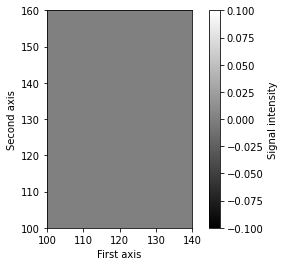

In [49]:
# show one slice of original mask
#sitk.Show(arr[100])
sitk_image = sitk.ReadImage(str(info_df_2.GTV_rtst_path[66]).replace("'", ""))
sitk_image.GetSize() # W, H, D
arr = sitk.GetArrayFromImage(sitk_image)
plt.imshow(arr[100], cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.axis([100, 140, 100, 160])
plt.show()

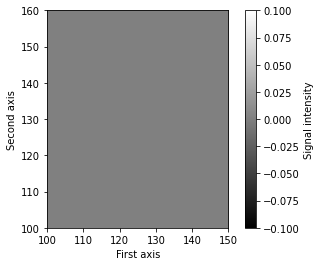

In [29]:
# show one slice of the eroded mask
plt.imshow(arr_new[15], cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.axis([100, 150, 100, 160])
plt.show()

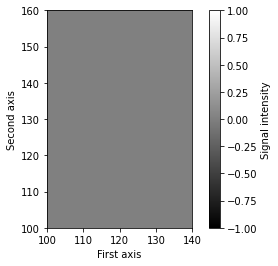

In [26]:
# show one slice of change of erosion
plt.imshow(arr_diff[70], cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.axis([100, 140, 100, 160])
plt.show()

#### Feature Extraction after Erosion & Dilation


In [150]:
# feature extraction after normalization
info_df_1 = pd.read_csv('match_paths04122.csv')
# remove 2 patients without data
info_df_2 = info_df_1.dropna().reset_index(drop=True) # num of rows = 293

# Method 1: count volume (voxel) change
for i in range(0, len(info_df_2)): # 87 error fraction 2
    sitk_image = sitk.ReadImage(str(info_df_2.GTV_rtst_path[i]).replace("'", ""))
    arr = sitk.GetArrayFromImage(sitk_image) # (144, 300, 334)
    arr_new = _contour_variance(arr) # (144, 300, 334)
    # create new images
    img_new = sitk.GetImageFromArray(arr_new)
    img_new.CopyInformation(sitk_image)
    try:
        sitk.WriteImage(img_new, info_df_2.GTV_rtst_path[i].replace('.nii.gz', '_ero.nii.gz'))
        print('patient_id:{} fraction_id:{} Erosion & Dilation'.format(info_df_2.patient_id[i], info_df_2.fraction[i]))
    except Exception as e:
        print('patient_id:{} fraction_id:{} error:{}'.format(info_df_2.patient_id[i], info_df_2.fraction[i], e))

patient_id:10025460949 fraction_id:1 Erosion & Dilation
patient_id:10025460949 fraction_id:2 Erosion & Dilation
patient_id:10025460949 fraction_id:3 Erosion & Dilation
patient_id:10025460949 fraction_id:4 Erosion & Dilation
patient_id:10025460949 fraction_id:5 Erosion & Dilation
patient_id:10022522758 fraction_id:1 Erosion & Dilation
patient_id:10022522758 fraction_id:2 Erosion & Dilation
patient_id:10022522758 fraction_id:3 Erosion & Dilation
patient_id:10022522758 fraction_id:4 Erosion & Dilation
patient_id:10022522758 fraction_id:5 Erosion & Dilation
patient_id:10020981121 fraction_id:1 Erosion & Dilation
patient_id:10020981121 fraction_id:2 Erosion & Dilation
patient_id:10020981121 fraction_id:3 Erosion & Dilation
patient_id:10020981121 fraction_id:4 Erosion & Dilation
patient_id:10020981121 fraction_id:5 Erosion & Dilation
patient_id:10066719518 fraction_id:1 Erosion & Dilation
patient_id:10066719518 fraction_id:2 Erosion & Dilation
patient_id:10066719518 fraction_id:3 Erosion & D

In [151]:
# feature extraction after normalization
info_df_1 = pd.read_csv('match_paths04122.csv')
# remove 2 patients without data
info_df_2 = info_df_1.dropna().reset_index(drop=True) # num of rows = 293
heart_df = pd.read_csv('heart_intensity_statistic_0428.csv')
# remove 2 patients with 0 median heart intensity
heart_df = heart_df[heart_df.Median != 0].reset_index(drop=True)
#imagePath = info_df_1.N4_mr_stored_path
#labelPath = info_df_1.GTV_rtst_path
#str(info_df.GTV_rtst_path[0])[1:-1].replace("'", "")

# define the parameters
params = {}
#params['binWidth'] = 25 # default value
params['normalize'] = True
#params['binWidth'] = 10 # 2nd try 
#params['binWidth'] = 1 # 3rd try
params['binCount'] = 64

#extractor = featureextractor.RadiomicsFeatureExtractor(**params)
extractor = RadiomicsFeatureExtractor(**params)
print("Extraction parameters:\n\t", extractor.settings)
print("Enabled filters2:\n\t", extractor.enabledImagetypes)  # Still the default settings
print("Enabled features:\n\t", extractor.enabledFeatures)  # Still the default settings

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details


Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': True, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binCount': 64}
Enabled filters2:
	 {'Original': {}}
Enabled features:
	 {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}


In [152]:
result_er = []
for i in range(0, len(info_df_2)): # 293
    result_er.append(extractor.execute(imageFilepath = info_df_2.N4_mr_stored_path[i], 
                                    maskFilepath = info_df_2.GTV_rtst_path[i].replace('.nii.gz', '_ero.nii.gz'),
                                    med = heart_df['Median'][i]))

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [153]:
# Method 2 for exporting data
# export Ordered Dict result as csv
import csv
result_1 = pd.DataFrame([result_er]).T
filename = 'binCount=64/run5/patient_features_0612_randint36_5.csv'
fieldnames = list(result_1[0][0].keys())
with open(filename, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Write the header row
    writer.writeheader()
    
    # Write the data rows
    writer.writerows(result_1[0])

df = pd.read_csv('binCount=64/run5/patient_features_0612_randint36_5.csv')
df['pat_id'] = info_df_2['patient_id']
df['fracion'] = info_df_2['fraction']
df.shape

(293, 131)

In [185]:
# convert result to dataframe
result_1 = pd.DataFrame([result_er]).T
df = pd.DataFrame(np.empty((0, 129)))
keys = [key for key, value in result_1[0][0].items()]
df.columns = keys # empty df with columns
for i in range(0,len(result_1)):
    idv = result_1[0][i]
    values = []
    for key, value in idv.items():
        values.append(value)
    df.loc[len(df)] = values
df.head()
df['pat_id'] = info_df_2['patient_id']
df['fracion'] = info_df_2['fraction']
#df.to_csv('patient_features_0420.csv')
# binwidth changed to 10
#df.to_csv('patient_features_0425.csv')
# binwidth changed to 1
#df.to_csv('patient_features_04252.csv')
# binwidth changed to 1 with new normalization method
#df.to_csv('patient_features_04282.csv')
# binwidth = 25, bincount = 64
df.to_csv('binCount=64/run2/patient_features_0612_randint36_2.csv')

##### Stability Test for Erosion & Dilation

In [154]:
info_df_1 = pd.read_csv('match_paths04122.csv')
# remove 2 patients without data
info_df_2 = info_df_1.dropna().reset_index(drop=True) # num of rows = 293
# read updated features
df1 = pd.read_csv('binCount=64/run5/patient_features_0612_randint36_5.csv')
df1['pat_id'] = info_df_2['patient_id']
df1['fracion'] = info_df_2['fraction']
# append info_df2 to df1
all_df2 = pd.concat([df1, info_df_2], axis=1)
all_df2 = all_df2.loc[:,~all_df2.columns.duplicated()]
all_df2 = all_df2.drop(['patient_id'], axis=1)
# add RTst after Erosion & Dilation
GTV_rtst_path_ers = []
for i in range(0, len(all_df2)):
    GTV_rtst_path_ers.append(all_df2['GTV_rtst_path'][i].replace('.nii.gz', '_ero.nii.gz'))
all_df2['GTV_rtst_path_er'] = GTV_rtst_path_ers
# drop patient 10074696369 with GTV_rtst_path: 
# ‘/Volumes/BWH-KANNLAB/Nancy/Lung_Cancer_Radiomics/Data/10074696369/2020-10-23_112827_54x47x43.25sec.BH/Struct_GTV_KA.nii.gz’ 
# before split dataframe to ysim_df
# number 241
#df = all_df2.drop(index=all_df2.iloc[241].name)

df = all_df2[all_df2.GTV_rtst_path_er != '/Volumes/BWH-KANNLAB/Nancy/Lung_Cancer_Radiomics/Data/10074696369/2020-10-23_112827_54x47x43.25sec.BH/Struct_GTV_KA_ero.nii.gz']
# simulation dataframe
ysim_df = pd.DataFrame(np.empty((0, len(df.columns))))
ysim_df.columns = df.columns
# F1 dataframe
y1_df = pd.DataFrame(np.empty((0, len(df.columns))))
y1_df.columns = df.columns
y2_df = pd.DataFrame(np.empty((0, len(df.columns))))
y2_df.columns = df.columns
y3_df = pd.DataFrame(np.empty((0, len(df.columns))))
y3_df.columns = df.columns
y4_df = pd.DataFrame(np.empty((0, len(df.columns))))
y4_df.columns = df.columns
y5_df = pd.DataFrame(np.empty((0, len(df.columns))))
y5_df.columns = df.columns
pat_ids = []
for val in np.unique(df['pat_id']):
    pat_ids.append(val)
    temp_sim = df.loc[(df['pat_id'] == val) & (df['fraction'] == 'sim')]
    temp_1 = df.loc[(df['pat_id'] == val) & (df['fraction'] == '1')]
    temp_2 = df.loc[(df['pat_id'] == val) & (df['fraction'] == '2')]
    temp_3 = df.loc[(df['pat_id'] == val) & (df['fraction'] == '3')]
    temp_4 = df.loc[(df['pat_id'] == val) & (df['fraction'] == '4')]
    temp_5 = df.loc[(df['pat_id'] == val) & (df['fraction'] == '5')]
    ysim_df = ysim_df.append(temp_sim) # len = 50
    y1_df = y1_df.append(temp_1) 
    y2_df = y2_df.append(temp_2)
    y3_df = y3_df.append(temp_3)
    y4_df = y4_df.append(temp_4)
    y5_df = y5_df.append(temp_5)
    
# switch row 35 & 36 for patient 10124679100
ysim_df.iloc[35], ysim_df.iloc[36] = ysim_df.iloc[36].copy(), ysim_df.iloc[35].copy()

ysim_df.to_csv('binCount=64/run5/ysim_df_er_0612_randint36_5.csv')
y1_df.to_csv('binCount=64/run5/y1_df_er_0612_randint36_5.csv')
y2_df.to_csv('binCount=64/run5/y2_df_er_0612_randint36_5.csv')
y3_df.to_csv('binCount=64/run5/y3_df_er_0612_randint36_5.csv')
y4_df.to_csv('binCount=64/run5/y4_df_er_0612_randint36_5.csv')
y5_df.to_csv('binCount=64/run5/y5_df_er_0612_randint36_5.csv')
df.to_csv('binCount=64/run5/all_patient_features_0612_randint36_5.csv')

In [155]:
# compare sims
feature_names = all_df2.columns[all_df2.columns.str.startswith('original_')]
# dataframe to record CCC values
ccc_df = pd.DataFrame(np.empty((0, len(feature_names))))
ccc_df.columns = feature_names
cccs = []
# ysim: simulation from standard run without erosion & dilation
ysim = pd.read_csv('/Users/yuhelin/Desktop/University/2022 Post-Fall/Kann Lab/Lung Cancer/binCount=64/ysim_df_0612.csv')
for col in feature_names:
    cccs.append(CCC(ysim[col], ysim_df[col]))
ccc_df.loc[0] = cccs
ccc_df.rename(index={0:'sim_sim'}, inplace=True)
ccc_dfT = ccc_df.T
# find ccc larger than 0.9
stable_fea_names = list(ccc_dfT[ccc_dfT.sim_sim > 0.9].index)
print('num of stable features:', len(stable_fea_names))
ccc_dfT.to_csv('binCount=64/run5/ccc_dfT_er_sims_randint36_5.csv')

num of stable features: 88


In [7]:
# 93, 82, 101, 97, 93
# havent change path to new path
ccc_df1 = pd.read_csv('binCount=64/run1/ccc_dfT_er_sims_randint36.csv')
ccc_df2 = pd.read_csv('binCount=64/run2/ccc_dfT_er_sims_randint36_2.csv')
ccc_df3 = pd.read_csv('binCount=64/run3/ccc_dfT_er_sims_randint36_3.csv')
ccc_df4 = pd.read_csv('binCount=64/run4/ccc_dfT_er_sims_randint36_4.csv')
ccc_df5 = pd.read_csv('binCount=64/run5/ccc_dfT_er_sims_randint36_5.csv')
# ccc values for all 5 runs
ccc_all_df = ccc_df1
ccc_all_df = ccc_all_df.rename(columns = {'sim_sim': '1', 'Unnamed: 0': 'Features'})
ccc_all_df['2'] = ccc_df2.sim_sim
ccc_all_df['3'] = ccc_df3.sim_sim
ccc_all_df['4'] = ccc_df4.sim_sim
ccc_all_df['5'] = ccc_df5.sim_sim
ccc_all_df2 = ccc_all_df.iloc[:,1:6]
ccc_all_df2 = ccc_all_df2.astype(float)
ccc_all_df2[ccc_all_df2 > 0.9] = 1
ccc_all_df2[ccc_all_df2 < 0.9] = 0
ccc_all_df2.insert(0,'Features', ccc_all_df['Features'])
#ccc_all_df2.to_csv('ccc_all_df2.csv')
# select stable features with value 1 in 5 runs
spatial_stable_features = list(ccc_all_df2.loc[(ccc_all_df2['1'] == 1) & 
                                               (ccc_all_df2['2'] == 1) & 
                                               (ccc_all_df2['3'] == 1) & 
                                               (ccc_all_df2['4'] == 1) & 
                                               (ccc_all_df2['5'] == 1)].Features)
len(spatial_stable_features) # 79

57

##### Stable Features
1. Select common spatial stable features from 5 runs (53)
2. Select stable features with both temporal (stable_fea_names) and spatial (spatial_stable_features) CCC values > 0.9
* len(stable_fea_names) = 53
* len(spatial_stable_features) = 79
--> result: len = 52

In [8]:
# temporal stable features: stable_fea_names, spatial stable features: spatial_stable_features
ccc_df = pd.read_csv('binCount=64/ccc_dfT_0612.csv')
stable_fea_names = list(ccc_df.loc[(ccc_df['sim_F1'] > 0.9)]['Unnamed: 0'])
common_list = [c for c in stable_fea_names if c in spatial_stable_features]
len(common_list)
common_list_df = pd.DataFrame(common_list, columns = ['common_list'])
print(len(common_list_df))
common_list_df.to_csv('binCount=64/common_list_0612.csv')

47


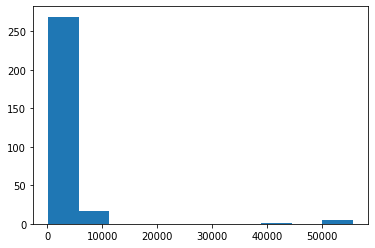

In [169]:
df = pd.read_csv('all_patient_features_0502.csv')
fig, ax = plt.subplots()
plt.hist(df['diagnostics_Mask-original_VoxelNum'])
plt.show()
fig.savefig('hist_VoxelNum_0502.jpg', format = 'jpg')